get the filename

In [67]:
import csv
import os
import pandas as pd
import numpy as np

dir_path = os.path.dirname(os.path.realpath('feature_selection.ipynb'))
datasets_folder = dir_path +'/datasets'

filenames = []
for file in os.listdir(datasets_folder):
    filenames.append(os.fsdecode(file))    

### dataset

In [68]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

def dataset_reshape(scaled):
    X_train = []
    y_train = []
    
    length = scaled.shape[0]
    for i in range(60,length):
        X_train.append(scaled[i-60:i,0])
        y_train.append(scaled[i,0])
    X_train,y_train = np.array(X_train),np.array(y_train)
    X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
    return X_train,y_train

def getdatasets_ml(filename):
    filename_new = filename.replace('.csv','')
    line,stationID,stationDIR = filename_new.split('_')
    cur_dir = datasets_folder+'/'+filename
    data = pd.read_csv(cur_dir,header=None)
    data.columns = ['month','date','hour','temp','pressure','humidity',
                   'wind_speed','wind_direction','clouds','weather_code',
                   'minute','delay']
    X = data[['hour','temp','pressure','humidity','wind_speed','clouds','weather_code','minute']]
    y = data.iloc[:,11]
    X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    
    return X_train,X_test, y_train, y_test

def getdatasets_lstm(filename):
    filename_new = filename.replace('.csv','')
    line,stationID,stationDIR = filename_new.split('_')
    cur_dir = datasets_folder+'/'+filename
    data = pd.read_csv(cur_dir,header=None)
    data.columns = ['month','date','hour','temp','pressure','humidity',
                   'wind_speed','wind_direction','clouds','weather_code',
                   'minute','delay']
    training_set = data.iloc[:,11:].values
    #training_set_reshape = training_set.reshape(-1,1)
    data_scaled = sc.fit_transform(training_set)
    train, test = train_test_split(data_scaled,test_size=0.1)
    X_train,y_train = dataset_reshape(train)
    X_test,y_test = dataset_reshape(test)
    
    return X_train, X_test, y_train, y_test

## random forest

In [69]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

regr = RandomForestRegressor(max_depth=2,random_state=0)    

## kernel ridge regression

In [70]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

def param_tuned(X_train,X_test, y_train, y_test):  
    tuned_parameters = [{'kernel':['rbf'],
                     'gamma':[1e-3,1e-4,1e-2,0.1,1],
                     'alpha':[0.1,1,10,100,1000]}]
    
    
    clf = GridSearchCV(KernelRidge(),tuned_parameters,cv=5)
    clf.fit(X_train,y_train)
    return clf.best_params_ 

def krr_model(X_train,X_test, y_train, y_test):
    param = param_tuned(X_train,X_test, y_train, y_test)
    krr =  KernelRidge(alpha=param['alpha'],kernel=param['kernel'],gamma=param['gamma'])
    return krr

## LSTM

In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

def rnn_regr(X_train,X_test,y_train,y_test):
    #Initialize the RNN
    regressor = Sequential()
    regressor.add(LSTM(units=50,return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressor.add(Dropout(0.3))

    # add a second LSTM layer
    regressor.add(LSTM(units = 32, return_sequences = True))
    regressor.add(Dropout(0.3))
    
    # add a forth LSTM layer
    regressor.add(LSTM(units = 32, return_sequences = False))
    regressor.add(Dropout(0.3))

    # add a output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    return regressor

In [72]:
def heatmap(train):
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))

    plt.title('correlation of features',y=1.05,size=15)
    sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [76]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=3):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(model)
                model.fit(X[train_index], y[train_index])
                y_pred = model.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2_201_S.csv
1.0634444729385564
1.03704705690007
(5924,)
(5924,)


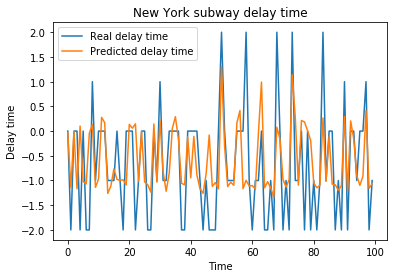

/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import pickle

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

def main_function(filenames,dir_path):
    mse_train_sum = 0
    mse_test_sum = 0
    for filename in filenames:
        X_ml_train,X_ml_test, y_ml_train, y_ml_test=getdatasets_ml(filename)
        X_lstm_train,X_lstm_test, y_lstm_train, y_lstm_test=getdatasets_lstm(filename)
        
        krr = krr_model(X_ml_train,X_ml_test, y_ml_train, y_ml_test)
        
        stacked_averaged_models = StackingAveragedModels(base_models = (regr, krr),meta_model = lasso)
        stacked_averaged_models.fit(X_ml_train.values, y_ml_train.values)
        
        model_dir = dir_path + '/models/'+ filename+'.sav'
        pickle.dump(stacked_averaged_models,open(model_dir,'wb'))
        
        # load the model from disk
        loaded_model = pickle.load(open(model_dir, 'rb'))
        
        y_train_pred = loaded_model.predict(X_ml_train)
        y_test_pred = loaded_model.predict(X_ml_test)
        
        mse_train = mean_squared_error(y_train_pred,y_ml_train)
        mse_test = mean_squared_error(y_test_pred,y_ml_test)
        
        mse_train_sum += mse_train
        mse_test_sum += mse_test
        
        print(filename)
        print(mse_train)
        print(mse_test)
        
        print(y_ml_train.shape)
        print(y_train_pred.shape)
        
        # Visualising the results
        y_ml_train=y_ml_train.tolist()
        y_train_pred=y_train_pred.tolist()
        plt.plot(y_ml_train[:100], label = 'Real delay time')
        plt.plot(y_train_pred[:100], label = 'Predicted delay time')
        plt.title('New York subway delay time')
        plt.xlabel('Time')
        plt.ylabel('Delay time')
        plt.legend()
        plt.show()
        
    mse_train_sum /= len(filenames)
    mse_test_sum /= len(filenames)
    
    print('average mse for training and testing are {},{}'.format(mse_train_sum,mse_test_sum))
main_function(filenames,dir_path)        